In [1]:
%pip install -q datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 101.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 14.9 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

ds = load_dataset('martingrzzler/mnemonics_benchmark')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/martingrzzler___json/martingrzzler--mnemonics_benchmark-6cc75b71b93e3c15/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
%pip install git+https://github.com/boudinfl/pke.git
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/boudinfl/pke.git to /tmp/pip-req-build-evu7r750
  Running command git clone --filter=blob:none --quiet https://github.com/boudinfl/pke.git /tmp/pip-req-build-evu7r750
  Resolved https://github.com/boudinfl/pke.git to commit f2d4f5d2252c64d23defccd32fdac8809cfd7ce0
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 9.1 MB/s eta 0:00:00
  Created wheel for pke: filename=pke-2.0.0-py3-none-any.whl size=6160676 sha256=d9d65f82f6c2b5a46f51616c74aab5a401ebb7fa899a6b26c1fd583a475d6079
  Stored in directory: /tmp/pip-ephem-wheel-cache-b2eudz1d/wheels/d5/46/97/85535b5b449f70b6a3c8d1138ce8587345876891e25bfe7954
Successfully built pke
2023-04-17 15:44:42.940070: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To 

In [4]:
import pke
import string
import re

stoplist = list(string.punctuation)
stoplist += pke.lang.stopwords.get('en')

def multi_partite_rank_extract(text, n):
    text = re.sub(r'<.*?>', '', text)
    multi_partite_rank = pke.unsupervised.MultipartiteRank()
    multi_partite_rank.load_document(input=text, language='en', stoplist=stoplist)
    pos = {'NOUN', 'PROPN', 'ADJ', 'VERB'}
    multi_partite_rank.candidate_selection(pos=pos)
    multi_partite_rank.candidate_weighting()
    return multi_partite_rank.get_n_best(n=n)

In [5]:
keys = ['gpt2xl_mnemonic', 'gpt3_mnemonic', 'gpt3_paragraph', 'wanikani_mnemonic']
sample = ds['train'][13]
input_words = [sample['kanji_meaning']] + sample['component_meanings'].split(',')
input_words

['distribute', 'alcohol', 'oneself']

In [6]:
multi_partite_rank_extract(sample['wanikani_mnemonic'],3)

[('alcohol', 0.16713240652112848),
 ('distribute', 0.1572303125007911),
 ('friends', 0.1286881116684249)]

In [7]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
ser_model = DistilBertForSequenceClassification.from_pretrained('martingrzzler/distilbert-sensory-modality').to(device)
img_model = DistilBertForSequenceClassification.from_pretrained('martingrzzler/distilbert-imageability').to(device)
concr_model = DistilBertForSequenceClassification.from_pretrained('martingrzzler/distilbert-phrase-word-concreteness').to(device)

In [9]:
def predict(token,model):
    inputs = tokenizer(token, return_tensors='pt').to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    return logits.item()

In [10]:
import numpy as np

def feature_score(keywords_with_scores,model):
    scores = [] 
    total_weight = 0
    for keyphrase, weight in keywords_with_scores:
        total_weight += weight
    
    for keyphrase, weight in keywords_with_scores:
        words = keyphrase.split(' ')
        score = np.mean([predict(word,model) for word in words])
        scores.append(score * weight / total_weight)

    return np.sum(scores)

def imageability_score(keywords_with_scores):
    return feature_score(keywords_with_scores,img_model)

def concreteness_score(keywords_with_scores):
    return feature_score(keywords_with_scores,concr_model)

def sensory_modality_score(keywords_with_scores):
    return feature_score(keywords_with_scores,ser_model)


In [12]:
def map_keywords_and_scores(example):
    for key in keys:
        keywords = multi_partite_rank_extract(example[key], n=10)
        example[key + '_keywords'] = [keyword for keyword, weight in keywords]
        example[key + '_keyword_scores'] = [weight for keyword, weight in keywords]

    return example

In [18]:
ds_keywords = ds['train'].map(map_keywords_and_scores)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [28]:
def map_img(example):
    input_words = [example['kanji_meaning']] + example['component_meanings'].split(',')
    for key in keys:
        keywords_with_scores = list(zip(example[key + '_keywords'], example[key + '_keyword_scores']))
        keywords_with_scores = keywords_with_scores[:len(input_words)]
        example[key + '_img'] = imageability_score(keywords_with_scores)
    return example

In [29]:
ds_img = ds_keywords.map(map_img)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [30]:
def map_concr(example):
    input_words = [example['kanji_meaning']] + example['component_meanings'].split(',')
    for key in keys:
        keywords_with_scores = list(zip(example[key + '_keywords'], example[key + '_keyword_scores']))
        keywords_with_scores = keywords_with_scores[:len(input_words)]
        example[key + '_concr'] = concreteness_score(keywords_with_scores)
    return example

In [31]:
def map_ser(example):
    input_words = [example['kanji_meaning']] + example['component_meanings'].split(',')
    for key in keys:
        keywords_with_scores = list(zip(example[key + '_keywords'], example[key + '_keyword_scores']))
        keywords_with_scores = keywords_with_scores[:len(input_words)]
        example[key + '_ser'] = sensory_modality_score(keywords_with_scores)
    return example

In [32]:
from scipy.stats import f_oneway
def anova(ds, feature):
    f, p = f_oneway(*[ds[key+'_'+feature] for key in keys])
    return f, p

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def box_plot(ds,title, feature, labels=['GPT-2','GPT-3 (mnemonic)','GPT-3 (paragraph)','WaniKani']):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title)
    ax.boxplot([ds[key+'_'+feature] for key in keys], labels=labels)
    plt.show()

In [34]:
from scipy.stats import tukey_hsd

def tukey(ds, feature):
    data = [ds[key+'_'+feature] for key in keys]
    res = tukey_hsd(*data)
    print(res)

In [38]:
def mean_std(ds, feature):
    return [(key, np.mean(ds[key+'_'+feature]), np.std(ds[key+'_'+feature])) for key in keys]

In [39]:
mean_std(ds_img, 'img')

[('gpt2xl_mnemonic', 0.5959762596571663, 0.09568548465647608),
 ('gpt3_mnemonic', 0.6702032033884232, 0.11156103478009173),
 ('gpt3_paragraph', 0.6357618975613843, 0.1113648557651364),
 ('wanikani_mnemonic', 0.6743005799170854, 0.11234894001517018)]

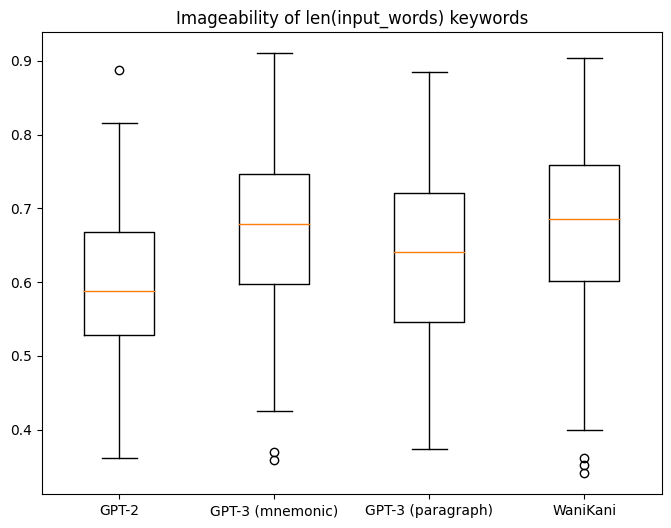

In [41]:
box_plot(ds_img,'Imageability of len(input_words) keywords', 'img')

In [45]:
print(anova(ds_img, 'img'))

(21.50461094184032, 2.252920153065692e-13)


In [47]:
tukey(ds_img, 'img')

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.074     0.000    -0.103    -0.046
 (0 - 2)     -0.040     0.002    -0.068    -0.011
 (0 - 3)     -0.078     0.000    -0.107    -0.050
 (1 - 0)      0.074     0.000     0.046     0.103
 (1 - 2)      0.034     0.011     0.006     0.063
 (1 - 3)     -0.004     0.983    -0.033     0.024
 (2 - 0)      0.040     0.002     0.011     0.068
 (2 - 1)     -0.034     0.011    -0.063    -0.006
 (2 - 3)     -0.039     0.003    -0.067    -0.010
 (3 - 0)      0.078     0.000     0.050     0.107
 (3 - 1)      0.004     0.983    -0.024     0.033
 (3 - 2)      0.039     0.003     0.010     0.067



In [48]:
ds_concr = ds_keywords.map(map_concr)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [49]:
print(anova(ds_concr, 'concr'))

(13.293960614608663, 1.830359751876866e-08)


In [50]:
mean_std(ds_concr, 'concr')

[('gpt2xl_mnemonic', 0.6135686785879915, 0.13731990906171015),
 ('gpt3_mnemonic', 0.6790303405884381, 0.15043729340963954),
 ('gpt3_paragraph', 0.6369914975777241, 0.15469572815133853),
 ('wanikani_mnemonic', 0.7005259952890661, 0.15171460872726958)]

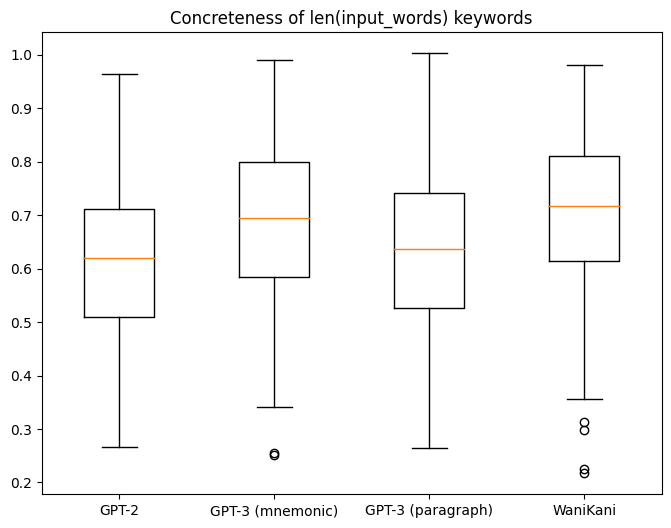

In [51]:
box_plot(ds_concr,'Concreteness of len(input_words) keywords', 'concr')

In [56]:
tukey(ds_concr, 'concr')

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.065     0.000    -0.105    -0.026
 (0 - 2)     -0.023     0.419    -0.063     0.016
 (0 - 3)     -0.087     0.000    -0.126    -0.048
 (1 - 0)      0.065     0.000     0.026     0.105
 (1 - 2)      0.042     0.031     0.003     0.081
 (1 - 3)     -0.021     0.496    -0.061     0.018
 (2 - 0)      0.023     0.419    -0.016     0.063
 (2 - 1)     -0.042     0.031    -0.081    -0.003
 (2 - 3)     -0.064     0.000    -0.103    -0.024
 (3 - 0)      0.087     0.000     0.048     0.126
 (3 - 1)      0.021     0.496    -0.018     0.061
 (3 - 2)      0.064     0.000     0.024     0.103



In [52]:
ds_ser = ds_keywords.map(map_ser)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [53]:
print(anova(ds_ser, 'ser'))

(1.6183958408359123, 0.1836719607291656)


In [54]:
mean_std(ds_ser, 'ser')

[('gpt2xl_mnemonic', 0.3856433868210609, 0.09081250275958626),
 ('gpt3_mnemonic', 0.38540509517852345, 0.10710109326401893),
 ('gpt3_paragraph', 0.38888836240214997, 0.10086088910498706),
 ('wanikani_mnemonic', 0.4051215511341284, 0.10561056783072986)]

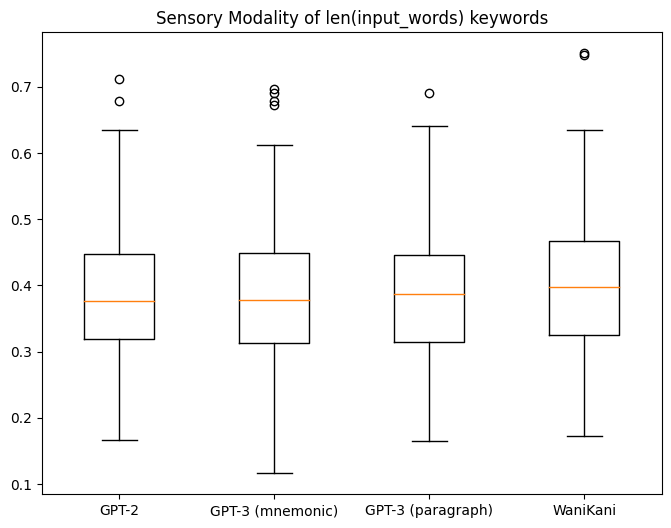

In [55]:
box_plot(ds_ser,'Sensory Modality of len(input_words) keywords', 'ser')

In [67]:
# sort ds_img mnemonics by imageability

ds_img_sorted = ds_img.to_pandas().sort_values(by='gpt2xl_mnemonic_img', ascending=False)

best = ds_img_sorted.iloc[1]
print(best['kanji_meaning'], best['component_meanings'], best['gpt2xl_mnemonic_img'])
print(best['gpt2xl_mnemonic_keywords'])
print(best['gpt2xl_mnemonic'])
print()
worst = ds_img_sorted.iloc[-1]
print(worst['kanji_meaning'], worst['component_meanings'], worst['gpt2xl_mnemonic_img'])
print(worst['gpt2xl_mnemonic_keywords'])
print(worst['gpt2xl_mnemonic'])

float tsunami,cleat,child 0.8164482881683226
['paddle board' 'kayak' 'stand' 'surfboard' 'sup' 'type' 'child' 'float'
 'designed' 'children ages']
This is a cleat that will allow you to float your child in the water. It's tsunami proof and can be used with any type of surfboard, kayak or stand up paddle board (SUP).


Designed for children ages 3-5 years old who are at least 5'2" tall but not more than 6 feet

ethics leader,hat,ground,bookshelf 0.361128496570412
['let' 'know' 'ideas' 'design' 'improved' 'helping' 'better' 'project'
 'feel free' 'leader ethics hat ground']
A leader ethics hat ground bookshelf.


This is my first attempt at a project like this, so please let me know if there's anything I can do to make it better! If you!re interested in helping out with any part of the design or just have some ideas on what could be improved (or not), feel free


In [69]:
ds_img_sorted = ds_img.to_pandas().sort_values(by='gpt3_mnemonic_img', ascending=False)

best = ds_img_sorted.iloc[0]
print(best['kanji_meaning'], best['component_meanings'], best['gpt3_mnemonic_img'])
print(best['gpt3_mnemonic_keywords'])
print(best['gpt3_mnemonic'])
print()
worst = ds_img_sorted.iloc[-1]
print(worst['kanji_meaning'], worst['component_meanings'], worst['gpt3_mnemonic_img'])
print(worst['gpt3_mnemonic_keywords'])
print(worst['gpt3_mnemonic'])

indigo flowers,oversee 0.9103364910768463
['flowers' 'garden' 'beautiful garden' 'making sure' 'healthy' 'variety'
 'admiring' 'overseen' 'blooming' 'wise old man named indigo']
Once upon a time, there was a beautiful garden with a variety of flowers. The garden was overseen by a wise old man named Indigo. He was responsible for making sure the flowers were healthy and blooming. He was so proud of the garden and the vibrant colors of the flowers. He would often stroll through the garden, admiring the beauty of the flowers and the peace that it brought to him.

axis car,reason 0.3593006033742908
['tried' 'way' 'wrong turn' 'remember' 'car' 'driving' 'taken' 'realize'
 'wrong axis' 'found']
Once upon a time, there was a man named Reason who was driving his car down the highway. He was so focused on the road ahead that he didn't realize he had taken a wrong turn and was now on the wrong axis. He tried to turn around but it was too late, and he was now hopelessly lost. He tried to remember

In [72]:
from evaluate import load

perplexity = load("perplexity", module_type="metric")

In [84]:
def map_ppl(example):
    input_words = [example['kanji_meaning']] + example['component_meanings'].split(',')
    for key in keys:
        keywords = example[key + '_keywords'][:len(input_words)]
        example[key + '_ppl'] = perplexity.compute(predictions=keywords,device=device, model_id='gpt2')['mean_perplexity']
    return example

In [ ]:
ds_ppl = ds_keywords.map(map_ppl)

In [89]:
print(anova(ds_ppl, 'ppl'))

(5.06033187850908, 0.001782361922987311)


In [90]:
mean_std(ds_ppl, 'ppl')

[('gpt2xl_mnemonic', 44713.206773078324, 62446.23853037061),
 ('gpt3_mnemonic', 59022.7572749767, 62221.15305382401),
 ('gpt3_paragraph', 74215.55234905946, 106608.15007185817),
 ('wanikani_mnemonic', 72263.5618881296, 93821.84312142144)]

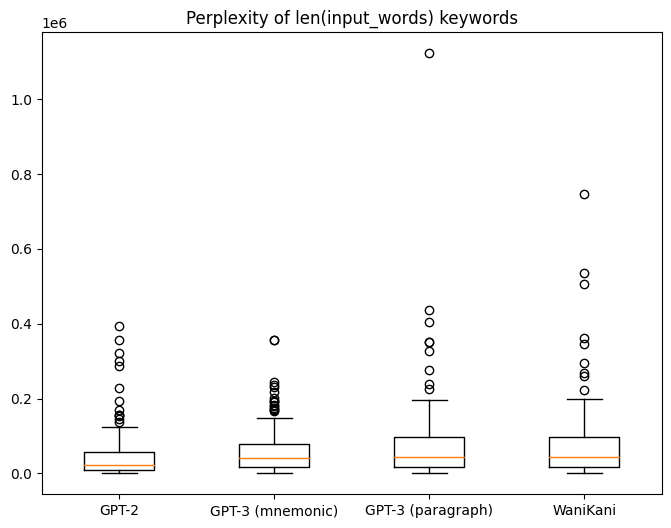

In [91]:
box_plot(ds_ppl,'Perplexity of len(input_words) keywords', 'ppl')